# Test task


Основные задачи:

 * На основе файла с данными («Raw data, test.xlsx») нужно рассчитать ROI нулевого дня, первой недели, месяца и шести месяцев для разных источников трафика в разных месяцах. Основной вопрос — какие источники окупаются, а какие — нет.
 
 
 
 * Также нужно построить график Cost per Registration для разных источников по дням. 

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Загрузка данных для анализа

In [2]:
# getting filename/path
file = 'Raw data, test.xlsx'

# getting sheetnames
xl = pd.ExcelFile(file)
sheetnames = xl.sheet_names

In [3]:
# splitting file into dataFrames according to sheetnames
cost,users,orders = [pd.read_excel(file,sheetname=sheet,) for sheet in sheetnames]

In [4]:
# check dtypes, null values, size, columns for cost df
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 3 columns):
date      642 non-null datetime64[ns]
source    642 non-null int64
cost      642 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 15.1 KB


In [5]:
# check dtypes, null values, size, columns for users df
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532531 entries, 0 to 532530
Data columns (total 3 columns):
id              532531 non-null int64
source          532531 non-null int64
date_created    532531 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 12.2 MB


In [6]:
# check dtypes, null values, size, columns for orders df
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59906 entries, 0 to 59905
Data columns (total 4 columns):
id            59906 non-null int64
id_user       59906 non-null int64
amount        59906 non-null float64
date_order    59906 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.8 MB


## Манипуляция данным: агрегация, обьединение и т.д

In [7]:
# converting dates 
orders['date_order'] = orders['date_order'].apply(lambda x:x.date())
users['date_created'] = users['date_created'] .apply(lambda x:x.date()) 

# merging into orders & users into single dataFrame
orders_user = pd.merge(orders,users,how = 'inner',right_on = 'id',left_on='id_user')
orders_user = orders_user[['id_x','amount','date_order','source']]

# grouping by index and source and aggregating order and amount columns
sorted_orders_user = orders_user.groupby(['date_order','source']).agg({'id_x':'count','amount':'sum'}).reset_index()

# sorting a dataFrame
sorted_orders_user = sorted_orders_user.sort_values(by=['source','date_order'])

# renaming a columns and index
columns = ['date_order','source','orders','amount']
sorted_orders_user.columns = columns

sorted_orders_user.head()

,date_order,source,orders,amount
0,2016-06-01,1,3,8.97
3,2016-06-02,1,6,33.94
6,2016-06-03,1,6,392.44
9,2016-06-04,1,5,202.95
12,2016-06-05,1,11,374.89


In [8]:
# converting timestamp to date for merging
cost['date'] = cost['date'].apply(lambda x: x.date())

# merging into single dataset
df = pd.merge(cost,sorted_orders_user, how = 'inner',left_on = ['date','source'],right_on=['date_order','source'],left_index=True)

# slicing a dataframe
df = df.loc[:,['date','cost','source','orders','amount']]
df.head()

,date,cost,source,orders,amount
0,2016-06-01,3653.903727,1,3,8.97
3,2016-06-02,3888.243754,1,6,33.94
6,2016-06-03,2595.855758,1,6,392.44
9,2016-06-04,2914.656690,1,5,202.95
12,2016-06-05,2886.238419,1,11,374.89


## ROI calc

Расчёт ROI проводился по стандартной формуле digital:

   <img src="https://help.elama.ru/hc/ru/article_attachments/204968189/image00__2_.png" style = "width: 60%"/>

In [9]:
# defining a roi-calc function
def roi(x):
    """calculate a return of investments for columns"""
    revenue = x[0]
    cost = x[1]
    return (revenue-cost)/cost*100

df.head()

,date,cost,source,orders,amount
0,2016-06-01,3653.903727,1,3,8.97
3,2016-06-02,3888.243754,1,6,33.94
6,2016-06-03,2595.855758,1,6,392.44
9,2016-06-04,2914.656690,1,5,202.95
12,2016-06-05,2886.238419,1,11,374.89


In [10]:
# setting indexes for main df
df.date = df.date.apply(lambda x: pd.to_datetime(x))
df.set_index('date',inplace = True)

In [11]:
# subsetting a dataframe by particular sources and stores them in separate dataframes
sources = df.source.unique()
s1,s2,s3 = [df[df['source']==x].drop('source',axis = 1) for x in sources]

# calculating a cumulative sums of cost and amount for each day 
source_1 = s1.groupby(s1.index).agg({'amount':'sum','cost':'sum'}).cumsum()
source_2 = s2.groupby(s2.index).agg({'amount':'sum','cost':'sum'}).cumsum()
source_3 = s3.groupby(s3.index).agg({'amount':'sum','cost':'sum'}).cumsum()

# calculating a ROI for each day by cumulative cost spent and amounts gained
source_1['roi'] = source_1[['amount','cost']].apply(roi,axis=1)
source_2['roi'] = source_2[['amount','cost']].apply(roi,axis=1)
source_3['roi'] = source_3[['amount','cost']].apply(roi,axis=1)

In [12]:
# defining a function that takes an index of datetime and return a ROI for periods
def get_rois(x_index):
    #x_index = x_index.index
    """get ROIs by date index in DataFrame in different periods"""
    zero_day = x_index.loc[(x_index.index.min())] # get first date
    week = x_index.loc[(x_index.index.min() + pd.DateOffset(weeks=1))]   # get first week
    month = x_index.loc[(x_index.index.min() + pd.DateOffset(months=1))] # get first month
    half_year = x_index[x_index.index.max()] # get 6 month
    return pd.Series([zero_day, week, month, half_year])


# getting roi for sources by periods
roi_s1 = source_1.loc[:,['roi']].apply(get_rois)
roi_s2 = source_2.loc[:,['roi']].apply(get_rois)
roi_s3 = source_3.loc[:,['roi']].apply(get_rois)

# concatenating into single dataFrame
roi_main = pd.concat([roi_s1,roi_s2,roi_s3],axis = 1)

# renaming index and columns
roi_main.index = ['0D','1W','1M','6M']
roi_main.columns = ['S1','S2','S3']

# main otput
roi_main

,S1,S2,S3
0D,-99.754509,-98.116090,-97.711885
1W,-92.751918,-88.176045,-94.683424
1M,-81.446343,-68.211241,-86.850710
6M,-38.687856,10.206712,-37.501230


Как видно с таблицы, источник 'S2' полностью окупает себя спустя полгода инвестирования. Источники 'S1' и 'S3' особенно неэффективны и требует оптимизации расходов, либо вовсе поиска альтернативы.


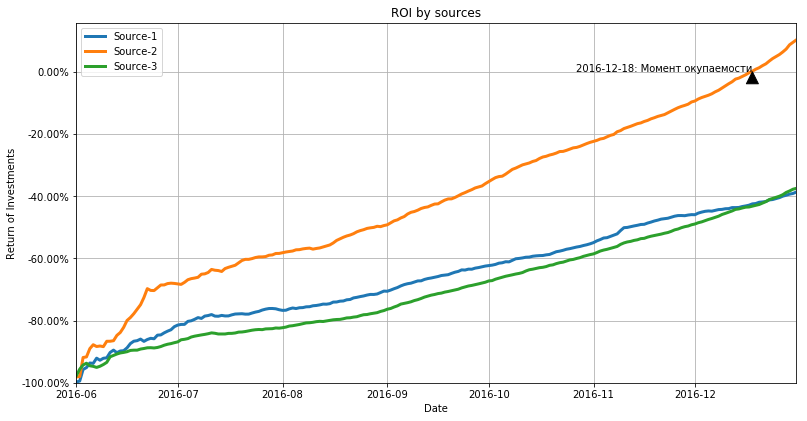

In [30]:
# creating a figure
fig = plt.figure(figsize = (10,5))

# creating axes
axes_1 = fig.add_axes([0,0,1,1])
axes_2 = fig.add_axes([0,0,1,1])
axes_3 = fig.add_axes([0,0,1,1])

# plotting
axes_1.plot(source_1['roi'],label ='Source-1',lw=3)
axes_2.plot(source_2['roi'],label ='Source-2',lw=3)
axes_3.plot(source_3['roi'],label ='Source-3',lw=3)

# customizing
plt.legend(loc='best')
plt.grid(which='major')
plt.xlim([source_1.index.min(),source_1.index.max()])
plt.ylim(-100)

# annotating axes
plt.xlabel('Date')
plt.ylabel('Return of Investments')
plt.title('ROI by sources')

# formating y axes
vals = axes_1.get_yticks()
axes_1.set_yticklabels(['{:3.2f}%'.format(x) for x in vals])

plt.tight_layout

x = source_2[source_2['roi'] > 0 ].idxmin()[0]
y = 0
plt.annotate('2016-12-18: Момент окупаемости',
             xy=(x,y),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize = 10,
            horizontalalignment = 'right')

# CPR - calculating

Расчёт CPR для дальнейшего анализа

In [15]:
# aggregating and sorting users data
users_main = users.groupby(['date_created','source'])['id'].count().reset_index().sort_values(by=['source','date_created'])

# converting date into datetime object
users_main['date_created'] = pd.to_datetime(users_main['date_created'])

# checking dtypes,null values, size
users_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 641
Data columns (total 3 columns):
date_created    642 non-null datetime64[ns]
source          642 non-null int64
id              642 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 20.1 KB


In [16]:
# handling mergin bug be reseting index for further merge
df.reset_index(inplace = True)

In [17]:
# mergin all aggregated dataframes into a single
main_df = pd.merge(df,users_main,left_on=['date','source'],right_on=['date_created','source'])

# creating column cpr for 'Cost Per Registration'
main_df['cpr'] = main_df.cost.div(main_df.id,0)

# drop unnecessary columns
main_df.drop('date_created',1,inplace = True)

main_df.set_index('date',inplace=True)
main_df.head()

,cost,source,orders,amount,id,cpr
date,,,,,,
2016-06-01,3653.903727,1,3,8.97,266,13.736480
2016-06-02,3888.243754,1,6,33.94,268,14.508372
2016-06-03,2595.855758,1,6,392.44,270,9.614281
2016-06-04,2914.656690,1,5,202.95,238,12.246457
2016-06-05,2886.238419,1,11,374.89,228,12.658940


In [18]:
# creating a subset for 
subset = main_df[['source','id','cost','cpr']]

# check dtypes
subset.dtypes

source      int64
id          int64
cost      float64
cpr       float64
dtype: object

In [19]:
# splitting data into different frames according to source
sources_cpr = subset.source.unique()
s1_cpr,s2_cpr,s3_cpr = [subset[subset['source']==x].drop('source',axis = 1) for x in sources_cpr]

# CPR - Visualization

Динамика изменеий CPR по источникам

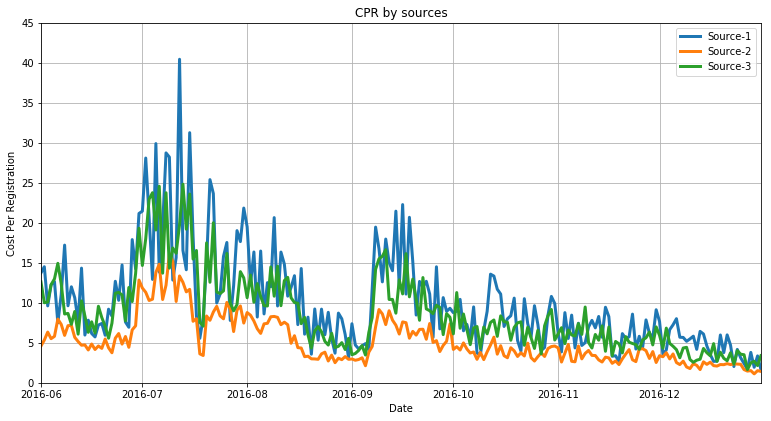

In [26]:
# creating a figure
fig = plt.figure(figsize = (10,5))

# creating axes
axes_1 = fig.add_axes([0,0,1,1])
axes_2 = fig.add_axes([0,0,1,1])
axes_3 = fig.add_axes([0,0,1,1])

# plotting
axes_1.plot(s1_cpr['cpr'],label ='Source-1',lw=3)
axes_2.plot(s2_cpr['cpr'],label ='Source-2',lw=3)
axes_3.plot(s3_cpr['cpr'],label ='Source-3',lw=3)

# customizing
plt.legend(loc='best')
plt.grid(which='major')

# customizing
plt.legend(loc='best')
plt.grid(True)
plt.xlim([s1_cpr.index.min(),s1_cpr.index.max()])
plt.ylim(0,45)
# annotating axes
plt.xlabel('Date')
plt.ylabel('Cost Per Registration')
plt.title('CPR by sources')

Еще один пример визуализации CPR по источникам.

<function matplotlib.pyplot.tight_layout>

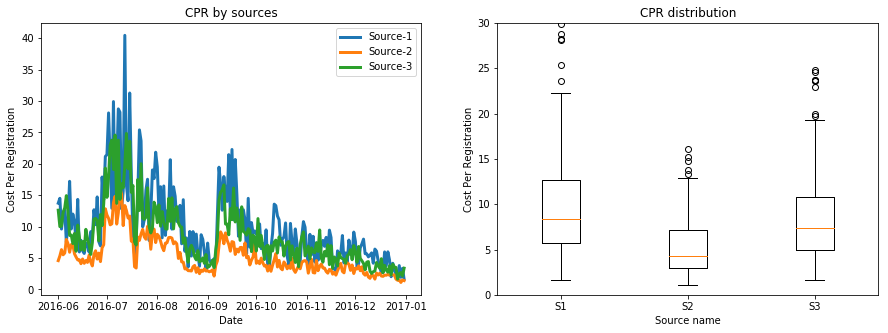

In [21]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,5) )

axes[0].plot(s1_cpr['cpr'],label ='Source-1',lw=3)
axes[0].plot(s2_cpr['cpr'],label ='Source-2',lw=3)
axes[0].plot(s3_cpr['cpr'],label ='Source-3',lw=3)

axes[0].legend()

axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cost Per Registration')
axes[0].set_title('CPR by sources')

axes[1].boxplot([s1_cpr['cpr'],s2_cpr['cpr'],s3_cpr['cpr']])
axes[1].set_xticklabels(['S1', 'S2', 'S3'])
axes[1].set_ylim(0,30)

axes[1].set_xlabel('Source name')
axes[1].set_ylabel('Cost Per Registration')
axes[1].set_title('CPR distribution')


plt.tight_layout

## Инсайты

**Источник 'S2'** - *окупается на протяжении 6 месяц*, также, *наиболее прибыльный* и относительно других - *менее затратный с точки зрения привлечения новых пользователей* исходя из самой низкой стоимости регистрации.

**Источник 'S1'** - *имеет наивысший CPR* и **не окупается** на протяжении полугодового инвестирования. Рекомендую оптимизировать расходы на этот источник либо распределить бюджет между остальными.

**Источник 'S3'** - не окупился за 6 месяцев, имеет средний CPR относительно 'S1' и 'S2'